# Ian Leung AI Skills Showcase

Hi, I'm Ian, a 1A student in CFM. Over the summer I had the opportunity to work at the Sunnybrook Research Institute, where I learned about how Machine Learning can be applied to Focused Ultrasound. I hope to further explore the intersection of AI and healthcare through this SEE-DR project. For my project, I decided to create a facial recognition model to identify K-Pop idols, because hot take: many of them look too similar (don't kill me I'm asian).

In [156]:
!pip install pandas==2.2.2 numpy==2.0.2 kagglehub opencv-contrib-python-headless matplotlib --quiet

## Step 1: Importing dataset and  images
I import dataset from kaggle and 2 images taken from google


In [157]:
import kagglehub as kh
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Kaggle dataset
path = kh.dataset_download('vkehfdl1/kidf-kpop-idol-dataset-female')
csv_path = os.path.join(path, "kid_f_train.csv")
df = pd.read_csv(csv_path)
print(df.head())

Using Colab cache for faster access to the 'kidf-kpop-idol-dataset-female' dataset.
  file_name   name
0     5.jpg  yujin
1     8.jpg  yujin
2    17.jpg  yujin
3    23.jpg  yujin
4    26.jpg  yujin


## Step 2: Displaying images
Simple display to understand test images

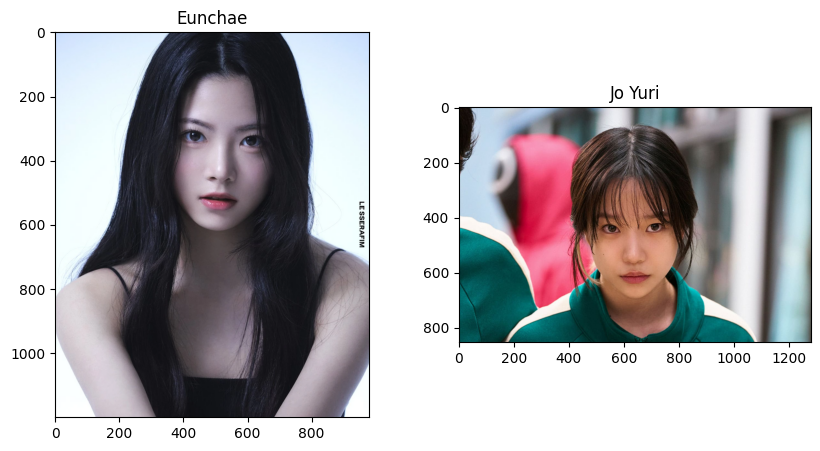

In [168]:
# Images
path_eunchae = "/content/images/Le-sserafim-hong-eunchae.webp"
path_joyuri = "/content/images/jo yuri.jpg"

img_eunchae = cv2.imread(path_eunchae)
img_joyuri = cv2.imread(path_joyuri)
rgb_img_eunchae = cv2.cvtColor(img_eunchae, cv2.COLOR_BGR2RGB)
rgb_img_joyuri = cv2.cvtColor(img_joyuri, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rgb_img_eunchae)
plt.title("Eunchae")

plt.subplot(1,2,2)
plt.imshow(rgb_img_joyuri)
plt.title("Jo Yuri")

plt.show()

## Step 3: Realize the dataset is incredibly biased
I spent so long (> 3 days.) (Missed the submission deadline bcuz of this) (im pissed) trying to find out why I kept getting blackpink members as predictions. Turns out the dataset has more blackpink pictures than the rest of the idols combined. I will restrict the model to 25 pictures max per idol to balance the dataset.

In [170]:
counts = df['name'].value_counts()
print(counts.head())

df = (
    df.groupby('name', group_keys=False)[df.columns]
      .apply(lambda x: x.sample(n=min(len(x), 25)))
      .reset_index(drop=True)
)

print("\nNew dataframe:\n", df['name'].value_counts().head())


name
choiyena       25
hongeunchae    25
hondahitomi    25
jennie         25
jisoo          25
Name: count, dtype: int64

New dataframe:
 name
choiyena       25
hongeunchae    25
hondahitomi    25
jennie         25
jisoo          25
Name: count, dtype: int64


## Step 4: Preprocessing and labelling
Converting the images to grayscale and creating numerical labels to train the facial recognition model

In [166]:
import numpy as np

# Convert to numeric labels
path_to_images = os.path.join(path, "HQ_512x512/HQ_512x512")
label_map = {}
name_map = {}
idols = []
ids = []
cur_label = 0

for _, row in df.iterrows():
    name = row["name"]
    img_path = os.path.join(path_to_images, row["file_name"])
    gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if name not in label_map:
        label_map[name] = cur_label
        name_map[cur_label] = name
        cur_label += 1

    idols.append(gray_img)
    ids.append(label_map[name])

## Step 4: Training model
Training facial recognizer off the dataset

In [161]:
import cv2
face_recognizer = cv2.face.LBPHFaceRecognizer_create()
face_recognizer.train(idols, np.array(ids))


# Step 5: Recognizing faces
Testing the model on my images.

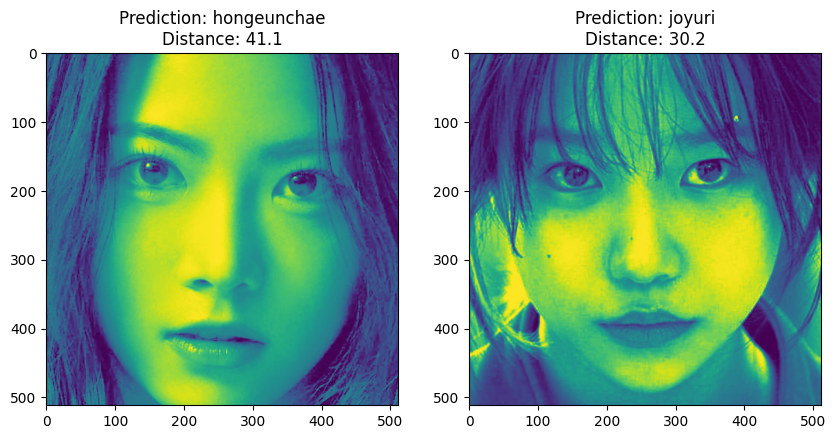

In [169]:
detector = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")

def predict_idol(img, rgb_img, index):
  """Runs facial recognition on idol and displays results using matplotlib"""
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(gray_img, scaleFactor=1.1,minNeighbors=5)

  # Lower distances are better
  best_label = None
  best_distance = float('inf')

  for (x, y, w, h) in faces:
      face_crop = gray_img[y:y+h, x:x+w]
      face_resized = cv2.resize(face_crop, (512, 512))
      face_resized = cv2.equalizeHist(face_resized)

      label, distance = face_recognizer.predict(face_resized)

      # Takes best face
      if distance < best_distance:
          best_distance = distance
          best_label = label

  name = name_map[best_label]

  plt.subplot(1,2,index)
  plt.imshow(face_resized)
  plt.title("Prediction: " + name + "\nDistance: " + str(round(distance, 1)))

plt.figure(figsize=(10,5))

predict_idol(img_eunchae, rgb_img_eunchae, 1) # Eunchae
predict_idol(img_joyuri, rgb_img_joyuri, 2) # Jo Yuri

plt.show()
